In [2]:
!pip install -r requirements.txt

import warnings
import pandas as pd
import logging
import os
import sys

from utils.LabelsDict import tickers
from utils.load_data import *

warnings.filterwarnings("ignore", category=UserWarning, message="Unable to import Axes3D")

from utils.portfolio import Portfolio

# Создаем директорию для логов если её нет
os.makedirs('logs', exist_ok=True)

# ПОЛНАЯ очистка всех логгеров
for name in list(logging.root.manager.loggerDict.keys()):
    logger = logging.getLogger(name)
    logger.handlers.clear()
    logger.filters.clear()
    logger.propagate = True
    logger.setLevel(logging.NOTSET)

# Полная очистка root логгера
logging.root.handlers.clear()
logging.root.filters.clear()

# Создаем ЕДИНСТВЕННЫЙ StreamHandler для stderr (как в Jupyter)
# Проверяем, что обработчиков нет, прежде чем добавлять
if not logging.root.handlers:
    handler = logging.StreamHandler(sys.stderr)
    handler.setLevel(logging.INFO)
    handler.setFormatter(logging.Formatter('%(asctime)s:%(name)s:%(levelname)s: %(message)s'))
    logging.root.addHandler(handler)
    logging.root.setLevel(logging.INFO)

# Отключаем DEBUG логи от Jupyter/VS Code компонентов
for logger_name in ['IPKernelApp', 'tornado', 'asyncio', 'jupyter', 'zmq', 'traitlets']:
    logging.getLogger(logger_name).setLevel(logging.WARNING)

# Очищаем логгер utils.portfolio от собственных обработчиков
portfolio_logger = logging.getLogger('utils.portfolio')
portfolio_logger.handlers.clear()
portfolio_logger.propagate = True

log = logging.getLogger(__name__)

from pycbrf.toolbox import ExchangeRates, Banks


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
tickers_list = [
    'GAZP', 'LKOH', 'ROSN',
    'SBER', 'VTBR', 'MOEX',
    'GMKN', 'NLMK', 'RUAL',
    'MTSS', 'RTKM', 'TTLK',
    'MGNT', 'LNTA', 'FESH',
] 

calc = Portfolio(
    dt_calc='2025-05-31',                                     # дата, до которой выгружаются данные
    dt_start='2019-11-03',                                    # максимальная глубина, которая есть на Финам
    stocks_step=10,                                           # указвыаем, что нужны месячные данные
    tickers_list=[
        'GAZP', 'LKOH', 'ROSN',
        'SBER', 'VTBR', 'MOEX',
        'GMKN', 'NLMK', 'RUAL',
        'MTSS', 'RTKM', 'TTLK',
        'MGNT', 'LNTA', 'FESH',
    ] 
)

In [10]:
calc.log_system_info()   

2025-11-04 20:19:09,891:utils.portfolio:INFO: ============================================================
2025-11-04 20:19:09,895:utils.portfolio:INFO: ANALYSIS STARTED | Python 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)] | Matplotlib 3.10.7
2025-11-04 20:19:09,899:utils.portfolio:INFO: ============================================================
2025-11-04 20:19:09,895:utils.portfolio:INFO: ANALYSIS STARTED | Python 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)] | Matplotlib 3.10.7
2025-11-04 20:19:09,899:utils.portfolio:INFO: ============================================================


In [4]:
calc = (
    calc
    # .log_system_info() уже вызвано в отдельной ячейке выше
    .load_stock_data(                                         # загрузка рыночных данных цен закрытия компаний
        use_backup_data=True,                                 # загружать данные из backup копии
        create_backup=False                                   # обновить backup копию (в случае есть получены новые данные)
    )
    .load_multipliers()                                       # выделить мультипликаторы из МСФО
    .create_portfolio()                                       # создать портфель с загруженными данными
    .adjust_portfolio_data_types()                            # провести настройку форматов дат и типов данных
    .add_macro_data()                                         # загрузить макропараметры
    .fill_missing_values()                                    # обработать пропуски в данных
    .add_dynamic_features()                                   # проставить динамические признаки по дате, например, квартал
    .add_merton_pd()                                          # выполнить расчет вероятности дефолта по формуле Мертона
    # .plot_pd_by_tickers(tickers=tickers_list, verbose=False)  # нарисовать графики для вероятностей дефолта
    # .plot_stocks(tickers=tickers_list, verbose=False)         # нарисовать динамику котировок акций
    # .plot_debt_capitalization(verbose=False)                  # нарисовать динамику долга и стоимости активов
    # .calc_irf(impulses_responses = {                          # расчитать функции импульсного отклика
    #     'inflation': 'PD', 'interest_rate': 'PD', 
    #     'rubusd_exchange_rate': 'PD', 'unemployment_rate': 'PD'
    # }, verbose=False)
    # .plot_correlation_matrix(custom_order = [                 # нарисовать матрицу корреляций
    #     'GAZP', 'LKOH', 'ROSN',                               # Нефтегазовая отрасль
    #     'SBER', 'VTBR', 'MOEX',                               # Финансовый сектор
    #     'GMKN', 'NLMK', 'RUAL',                               # Металлургия
    #     'MTSS', 'RTKM', 'TTLK',                               # Телекоммуникации
    #     'MGNT', 'LNTA', 'FESH'                                # Розничная торговля
    # ], verbose=False)
    # .calc_macro_connections()                                 # расчитать регрессию для макропараметров
    # .log_completion()                                         # вывести в лог сообщение об окончании расчета
)

2025-11-04 20:02:41,465:utils.portfolio:INFO: Stocks data loaded from backup | Records: 855
2025-11-04 20:02:42,121:utils.portfolio:INFO: Multipliers data loaded | Features: ['ticker', 'year', 'quarter', 'EV/EBITDA', 'P/BV', 'P/E', 'P/FCF', 'P/S', 'Долг, млрд руб', 'Долг/EBITDA', 'Капитализация, млрд руб', 'Чистый долг, млрд руб']
2025-11-04 20:02:42,130:utils.portfolio:INFO: Portfolio created | Companies: 15
2025-11-04 20:02:42,173:utils.portfolio:INFO: Column types adjusted: ['Долг, млрд руб', 'Капитализация, млрд руб', 'Чистый долг, млрд руб', 'high', 'low', 'close', 'EV/EBITDA', 'P/BV', 'P/E', 'P/S', 'open', 'Долг/EBITDA']
2025-11-04 20:02:42,841:utils.load_data:INFO: Backup file for usd/rub exchange rates was updated.New dates range: 2019-11-03 : 2025-05-31
2025-11-04 20:02:42,866:utils.portfolio:INFO: Macro indicators added: Interest rate, Unemployment, Inflation, USD/RUB
2025-11-04 20:02:42,904:utils.portfolio:INFO: Missing values share in: Debt (33.6 %),Cap (13.0 %), USD/RUB (0

2025-11-04 19:05:51,754:utils.portfolio:INFO: Multipliers data loaded | Features: ['ticker', 'year', 'quarter', 'EV/EBITDA', 'P/BV', 'P/E', 'P/FCF', 'P/S', 'Долг, млрд руб', 'Долг/EBITDA', 'Капитализация, млрд руб', 'Чистый долг, млрд руб']
2025-11-04 19:05:51,762:utils.portfolio:INFO: Portfolio created | Companies: 15
2025-11-04 19:05:51,762:utils.portfolio:INFO: Portfolio created | Companies: 15
2025-11-04 19:05:51,799:utils.portfolio:INFO: Column types adjusted: ['Долг, млрд руб', 'Капитализация, млрд руб', 'Чистый долг, млрд руб', 'high', 'low', 'close', 'EV/EBITDA', 'P/BV', 'P/E', 'P/S', 'open', 'Долг/EBITDA']
2025-11-04 19:05:51,799:utils.portfolio:INFO: Column types adjusted: ['Долг, млрд руб', 'Капитализация, млрд руб', 'Чистый долг, млрд руб', 'high', 'low', 'close', 'EV/EBITDA', 'P/BV', 'P/E', 'P/S', 'open', 'Долг/EBITDA']
2025-11-04 19:05:52,238:utils.load_data:INFO: Backup file for usd/rub exchange rates was updated.New dates range: 2019-11-03 : 2025-05-31
2025-11-04 19:05:

In [ ]:
# Извлекаем текущие статистики PD для использования в последующих ячейках
# Это необходимо для ячеек с кредитным анализом
current_pd_stats = calc.portfolio.groupby('ticker')['PD'].last()
print(f"Статистики PD загружены для {len(current_pd_stats)} компаний")
print(f"Средняя PD: {current_pd_stats.mean()*100:.2f}%")

In [5]:
calc.portfolio

,ticker,date,time,open,high,low,close,quarter,year,EV/EBITDA,...,debt,Долг/EBITDA,capitalization,interest_rate,inflation,Year,unemployment_rate,rubusd_exchange_rate,quarterly_volatility,PD
796,FESH,2019-12-31,000000,7.70,9.700,7.500,8.81,4,2019,4.83,...,3.290000e+10,2.65,2.600000e+10,0.0625,0.0300,2019,0.046,61.9057,0.4,0.000582
797,FESH,2020-01-31,000000,8.89,9.070,8.110,8.60,1,2020,NaN,...,3.290000e+10,NaN,2.600000e+10,0.0625,0.0240,2020,0.058,63.0359,0.4,0.000582
798,FESH,2020-02-29,000000,8.62,9.390,6.900,7.07,1,2020,NaN,...,3.290000e+10,NaN,2.600000e+10,0.0600,0.0230,2020,0.058,66.9909,0.4,0.000585
799,FESH,2020-03-31,000000,7.29,7.770,4.610,5.74,1,2020,NaN,...,3.290000e+10,NaN,2.600000e+10,0.0600,0.0250,2020,0.058,77.7325,0.4,0.000585
800,FESH,2020-04-30,000000,5.70,7.180,5.610,6.44,2,2020,4.80,...,3.320000e+10,2.81,2.140000e+10,0.0550,0.0310,2020,0.058,73.6894,0.4,0.000897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,VTBR,2024-06-30,000000,99.65,108.800,93.175,105.70,2,2024,NaN,...,1.101000e+12,NaN,5.664000e+11,0.1600,0.0859,2024,0.025,85.7480,0.4,0.001110
291,VTBR,2024-07-31,000000,105.85,106.975,91.650,97.82,3,2024,NaN,...,1.751000e+12,NaN,4.841000e+11,0.1800,0.0913,2024,0.025,86.3300,0.4,0.002410
292,VTBR,2024-08-31,000000,97.80,102.000,91.000,91.48,3,2024,NaN,...,1.751000e+12,NaN,4.841000e+11,0.1800,0.0905,2024,0.025,91.1868,0.4,0.002410
293,VTBR,2024-09-30,000000,90.95,94.600,83.810,89.03,3,2024,NaN,...,1.751000e+12,NaN,4.841000e+11,0.1900,0.0863,2024,0.025,92.7126,0.4,0.002386


In [6]:
def get_rubusd_exchange_rate(
    update_backup: bool=False,
    use_backup: bool=False
) -> pd.DataFrame:

    rubusd_df_path = f'data/macro/rubusd.csv'
    
    if use_backup:
        rates = pd.read_csv(rubusd_df_path)
        print(f'Exchange rates for usd/rub will be use from backup. Last actual date: {rates.date.max()}')
        return rates

    if os.path.exists(rubusd_df_path):
        
        rates = pd.read_csv(rubusd_df_path)
        start_date = rates.date.max()
    else:
        start_date = calc.dt_start

        date_range = pd.date_range(
            start=pd.to_datetime(start_date, format='%Y-%m-%d'),  # Исправлен формат на ISO8601
            end=pd.to_datetime(calc.dt_calc, format='%Y-%m-%d'),   # Исправлен формат на ISO8601
            freq='D' 
        )

        rates_additional = []
        for date in tqdm(date_range[-10:]):
            rates_additional.append(
                (date.strftime('%Y.%m.%d'), float(ExchangeRates(date)['USD'].value))
            )
        
        rates = (
            pd.DataFrame(rates_additional, columns=['date', 'rubusd_exchange_rate'])
            if not os.path.exists(rubusd_df_path)
            else pd.concat(rates, pd.DataFrame(rates_additional, columns=rates.columns))
        )

    if update_backup:
        rates.to_csv(rubusd_df_path, index=False)
        print(f'Backup file for usd/rub exchange rates was updated. New actual date: {rates.date.max()}')

    return rates

In [7]:
get_rubusd_exchange_rate(use_backup=True,update_backup=False)

Exchange rates for usd/rub will be use from backup. Last actual date: 2025-05-31


,date,rubusd_exchange_rate
0,2019-11-03,64.0316
1,2019-11-04,64.0316
2,2019-11-05,64.0316
3,2019-11-06,63.2480
4,2019-11-07,63.5880
...,...,...
2032,2025-05-27,79.6588
2033,2025-05-28,79.6176
2034,2025-05-29,79.6037
2035,2025-05-30,78.4970


In [8]:
!cp logs/graphs/GAZP_pd.png text/img/GAZP_pd.png
!cp logs/graphs/irf_inflation_PD.png text/img/irf_inflation_PD.png
!cp logs/graphs/irf_interest_rate_PD.png text/img/irf_interest_rate_PD.png
!cp logs/graphs/corr_matrix.png text/img/corr_matrix.png

'cp' is not recognized as an internal or external command,
operable program or batch file.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'cp' is not recognized as an internal or external command,
operable program or batch file.


# 🏦 ДЕМОНСТРАЦИЯ СИСТЕМЫ УПРАВЛЕНИЯ КРЕДИТНЫМ ПОРТФЕЛЕМ

Практический пример применения модели Мертона для управления кредитным портфелем банка.

In [9]:
# ========================================================================
# ЭТАП 1: НАСТРОЙКА СИСТЕМЫ КРЕДИТНОГО РИСКА
# ========================================================================

log.info("ЭТАП 1: Настройка системы кредитного риска")
credit_manager = calc

# Устанавливаем консервативные банковские лимиты
credit_manager.create_credit_risk_limits(
    max_pd_threshold=0.05,      # 5% - максимальная PD для одобрения
    max_sector_concentration=0.25,  # 25% - максимум в одном секторе  
    max_single_exposure=0.08    # 8% - максимум на одного заемщика
)

credit_manager.analyze_portfolio_status()


2025-11-04 20:02:47,173:__main__:INFO: ЭТАП 1: Настройка системы кредитного риска
2025-11-04 20:02:47,176:utils.portfolio:INFO: Лимиты кредитного риска установлены:
2025-11-04 20:02:47,178:utils.portfolio:INFO:    • Максимальная PD: 5.0%
2025-11-04 20:02:47,180:utils.portfolio:INFO:    • Секторная концентрация: 25.0%
2025-11-04 20:02:47,183:utils.portfolio:INFO:    • Доля одного заемщика: 8.0%
2025-11-04 20:02:47,188:utils.portfolio:INFO: Текущее состояние потенциальных заемщиков:
2025-11-04 20:02:47,190:utils.portfolio:INFO:    • Средняя PD: 0.000 (0.04%)
2025-11-04 20:02:47,192:utils.portfolio:INFO:    • Компании с PD <= 5%: 15/15
2025-11-04 20:02:47,195:utils.portfolio:INFO:    • Компании с высоким риском (PD > 5%): 0
2025-11-04 20:02:47,198:utils.portfolio:INFO: ТОП-5 НАИБОЛЕЕ НАДЕЖНЫХ ЗАЕМЩИКОВ:
2025-11-04 20:02:47,201:utils.portfolio:INFO:    TTLK: PD = 0.000 (0.00%)
2025-11-04 20:02:47,202:utils.portfolio:INFO:    LKOH: PD = 0.000 (0.00%)
2025-11-04 20:02:47,203:utils.portfolio:

In [10]:
# ========================================================================
# ЭТАП 2: ОБРАБОТКА КРЕДИТНЫХ ЗАЯВОК
# ========================================================================

log.info("ЭТАП 2: Обработка поступивших кредитных заявок")

# Симулируем реальные кредитные заявки от компаний
credit_applications = [
    {
        'ticker': 'SBER', 
        'amount': 100000000, 
        'purpose': 'Развитие розничного бизнеса',
        'term': 36  # месяцев
    },
    {
        'ticker': 'GAZP', 
        'amount': 150000000, 
        'purpose': 'Инвестиции в газодобычу',
        'term': 60
    },
    {
        'ticker': 'VTBR', 
        'amount': 80000000, 
        'purpose': 'Рефинансирование долгов',
        'term': 24
    },
    {
        'ticker': 'LKOH', 
        'amount': 200000000, 
        'purpose': 'Модернизация НПЗ',
        'term': 84
    },
    {
        'ticker': 'GMKN', 
        'amount': 120000000, 
        'purpose': 'Расширение горнодобычи',
        'term': 48
    }
]

portfolio_budget = 1000000000  # Кредитный бюджет банка: 1 млрд рублей

log.info(f"Поступило {len(credit_applications)} кредитных заявок на общую сумму {sum(app['amount'] for app in credit_applications)/1e6:.0f} млн руб.")
log.info(f"Доступный бюджет банка: {portfolio_budget/1e6:.0f} млн руб.")

# Обрабатываем каждую заявку
loan_decisions = []

for i, app in enumerate(credit_applications, 1):
    log.info(f"Обработка заявки #{i}: {app['ticker']}")
    log.info(f"  Сумма: {app['amount']/1e6:.0f} млн руб., Срок: {app['term']} мес., Цель: {app['purpose']}")
    
    # Используем метод assess_credit_application из класса Portfolio
    try:
        decision = credit_manager.assess_credit_application(
            borrower_ticker=app['ticker'],
            loan_amount=app['amount'],
            current_portfolio_size=portfolio_budget  # Исправлен параметр
        )
        
        loan_decisions.append({**app, **decision})
        
        # Логируем решение системы (без эмодзи)
        status_text = "ОДОБРЕНО" if decision['decision'] == 'ОДОБРИТЬ' else "УСЛОВНО" if decision['decision'] == 'УСЛОВНО ОДОБРИТЬ' else "ОТКЛОНЕНО"
        
        log.info(f"  Решение: {decision['decision']} ({status_text})")
        log.info(f"  PD заемщика: {decision['pd']:.3f} ({decision['pd']*100:.2f}%)")
        log.info(f"  Кредитный рейтинг: {decision['risk_rating']}")
        log.info(f"  Рекомендуемая ставка: {decision['recommended_rate']:.2%}")
        log.info(f"  Доля в портфеле: {decision['exposure_ratio']:.2%}")
        log.info(f"  Сектор: {decision['sector']}")
        log.info(f"  Обоснование: {decision['reason']}")
        
    except Exception as e:
        log.error(f"Ошибка при обработке заявки {app['ticker']}: {str(e)}")

# Сводная статистика решений
approved = [d for d in loan_decisions if d['decision'] == 'ОДОБРИТЬ']
rejected = [d for d in loan_decisions if d['decision'] == 'ОТКЛОНИТЬ']
conditional = [d for d in loan_decisions if d['decision'] == 'УСЛОВНО ОДОБРИТЬ']

log.info("ИТОГИ РАССМОТРЕНИЯ ЗАЯВОК:")
log.info(f"Одобрено: {len(approved)} заявок")
log.info(f"Отклонено: {len(rejected)} заявок")
log.info(f"Условно одобрено: {len(conditional)} заявок")

if approved:
    approved_amount = sum(d['loan_amount'] if 'loan_amount' in d else d['amount'] for d in approved)
    avg_pd = sum(d['pd'] for d in approved) / len(approved)
    avg_rate = sum(d['recommended_rate'] for d in approved) / len(approved)
    
    log.info(f"Одобренная сумма: {approved_amount/1e6:.1f} млн руб.")
    log.info(f"Средняя PD одобренных: {avg_pd:.3f} ({avg_pd*100:.2f}%)")
    log.info(f"Средняя ставка: {avg_rate:.2%}")
    log.info(f"Использование бюджета: {approved_amount/portfolio_budget:.1%}")

2025-11-04 20:02:47,364:__main__:INFO: ЭТАП 2: Обработка поступивших кредитных заявок
2025-11-04 20:02:47,366:__main__:INFO: Поступило 5 кредитных заявок на общую сумму 650 млн руб.
2025-11-04 20:02:47,368:__main__:INFO: Доступный бюджет банка: 1000 млн руб.
2025-11-04 20:02:47,372:__main__:INFO: Обработка заявки #1: SBER
2025-11-04 20:02:47,373:__main__:INFO:   Сумма: 100 млн руб., Срок: 36 мес., Цель: Развитие розничного бизнеса
2025-11-04 20:02:47,376:__main__:INFO:   Решение: УСЛОВНО ОДОБРИТЬ (УСЛОВНО)
2025-11-04 20:02:47,378:__main__:INFO:   PD заемщика: 0.000 (0.00%)
2025-11-04 20:02:47,380:__main__:INFO:   Кредитный рейтинг: AAA (Высший)
2025-11-04 20:02:47,382:__main__:INFO:   Рекомендуемая ставка: 18.00%
2025-11-04 20:02:47,385:__main__:INFO:   Доля в портфеле: 10.00%
2025-11-04 20:02:47,388:__main__:INFO:   Сектор: Финансы
2025-11-04 20:02:47,390:__main__:INFO:   Обоснование: Высокая концентрация: 10.0% от портфеля
2025-11-04 20:02:47,392:__main__:INFO: Обработка заявки #2: G

In [11]:
# ========================================================================
# ЭТАП 3: ОПТИМИЗАЦИЯ КРЕДИТНОГО ПОРТФЕЛЯ
# ========================================================================

import datetime

log.info("ЭТАП 3: Оптимизация состава кредитного портфеля")

# Функция оптимизации портфеля (упрощенная версия)
def optimize_portfolio(applications, budget, credit_manager):
    """Упрощенная оптимизация кредитного портфеля"""
    
    # Оцениваем каждую заявку используя метод класса Portfolio
    evaluated_apps = []
    for app in applications:
        try:
            # Используем assess_credit_application из класса Portfolio
            assessment = credit_manager.assess_credit_application(
                borrower_ticker=app['ticker'],
                loan_amount=app['amount'], 
                current_portfolio_size=budget  # Исправлен параметр
            )
            
            if assessment['decision'] in ['ОДОБРИТЬ', 'УСЛОВНО ОДОБРИТЬ']:
                app_copy = app.copy()
                app_copy.update(assessment)
                app_copy['risk_adjusted_return'] = app['rate'] - assessment['pd']
                evaluated_apps.append(app_copy)
                
        except Exception as e:
            log.error(f"Ошибка при оценке заявки {app['ticker']}: {str(e)}")
            continue
    
    # Сортируем по риск-скорректированной доходности
    evaluated_apps.sort(key=lambda x: x['risk_adjusted_return'], reverse=True)
    
    # Формируем оптимальный портфель
    selected_loans = []
    total_allocated = 0
    sector_allocation = {}
    
    for app in evaluated_apps:
        if total_allocated + app['amount'] <= budget:
            sector = app['sector']
            current_sector_alloc = sector_allocation.get(sector, 0)
            new_sector_alloc = (current_sector_alloc + app['amount']) / budget
            
            # Проверяем секторный лимит
            if new_sector_alloc <= credit_manager.credit_limits['max_sector_concentration']:
                selected_loans.append(app)
                total_allocated += app['amount']
                sector_allocation[sector] = current_sector_alloc + app['amount']
    
    # Расчет метрик портфеля
    if total_allocated > 0:
        portfolio_return = sum(loan['amount'] * loan['rate'] for loan in selected_loans) / total_allocated
        portfolio_pd = sum(loan['amount'] * loan['pd'] for loan in selected_loans) / total_allocated
    else:
        portfolio_return = 0
        portfolio_pd = 0
    
    return {
        'selected_loans': selected_loans,
        'total_allocated': total_allocated,
        'portfolio_budget': budget,
        'utilization_rate': total_allocated / budget,
        'portfolio_return': portfolio_return,
        'portfolio_pd': portfolio_pd,
        'portfolio_spread': portfolio_return - portfolio_pd,
        'sector_allocation': {k: v/budget for k, v in sector_allocation.items()},
        'number_of_loans': len(selected_loans),
        'rejected_applications': len(applications) - len(selected_loans)
    }

# Расширенный список заявок для демонстрации оптимизации
extended_applications = [
    {'ticker': 'SBER', 'amount': 100000000, 'rate': 0.09},
    {'ticker': 'GAZP', 'amount': 150000000, 'rate': 0.10},
    {'ticker': 'VTBR', 'amount': 80000000, 'rate': 0.12},
    {'ticker': 'LKOH', 'amount': 200000000, 'rate': 0.105},
    {'ticker': 'GMKN', 'amount': 120000000, 'rate': 0.11},
    {'ticker': 'ROSN', 'amount': 90000000, 'rate': 0.108},
    {'ticker': 'NLMK', 'amount': 70000000, 'rate': 0.13},
    {'ticker': 'MTSS', 'amount': 60000000, 'rate': 0.14},
    {'ticker': 'MGNT', 'amount': 50000000, 'rate': 0.16},
    {'ticker': 'MOEX', 'amount': 40000000, 'rate': 0.11},
]

log.info(f"Оптимизация из {len(extended_applications)} заявок...")
log.info(f"Общий запрос: {sum(app['amount'] for app in extended_applications)/1e6:.0f} млн руб.")
log.info(f"Доступный бюджет: {portfolio_budget/1e6:.0f} млн руб.")

# Запускаем алгоритм оптимизации
optimal_portfolio = optimize_portfolio(
    extended_applications, 
    portfolio_budget, 
    credit_manager
)

log.info("РЕЗУЛЬТАТЫ ОПТИМИЗАЦИИ:")
log.info(f"Размещено средств: {optimal_portfolio['total_allocated']/1e6:.1f} млн из {optimal_portfolio['portfolio_budget']/1e6:.0f} млн")
log.info(f"Коэффициент использования: {optimal_portfolio['utilization_rate']:.1%}")
log.info(f"Портфельная доходность: {optimal_portfolio['portfolio_return']:.2%}")
log.info(f"Портфельная PD: {optimal_portfolio['portfolio_pd']*100:.2f}%")
log.info(f"Риск-премия (Доходность - PD): {optimal_portfolio['portfolio_spread']:.2%}")
log.info(f"Кредитов в портфеле: {optimal_portfolio['number_of_loans']}")
log.info(f"Отклоненных заявок: {optimal_portfolio['rejected_applications']}")

if optimal_portfolio['selected_loans']:
    log.info("СОСТАВ ОПТИМАЛЬНОГО КРЕДИТНОГО ПОРТФЕЛЯ:")
    for loan in optimal_portfolio['selected_loans']:
        amount_mln = loan['amount'] / 1e6
        share = loan['amount'] / optimal_portfolio['total_allocated']
        log.info(f"  {loan['borrower']}: {amount_mln:.1f} млн руб. ({share:.1%}), Ставка: {loan['rate']:.1%}, PD: {loan['pd']*100:.2f}%, Сектор: {loan['sector']}")

# Секторная диверсификация
log.info("СЕКТОРНАЯ ДИВЕРСИФИКАЦИЯ:")
for sector, allocation in optimal_portfolio['sector_allocation'].items():
    if allocation > 0:
        log.info(f"  {sector}: {allocation:.1%}")

log.info("Создан оптимальный портфель с соблюдением всех лимитов риска!")
log.info(f"Достигнута доходность {optimal_portfolio['portfolio_return']:.2%} при PD {optimal_portfolio['portfolio_pd']*100:.2f}%")

2025-11-04 20:04:03,348:__main__:INFO: ЭТАП 3: Оптимизация состава кредитного портфеля
2025-11-04 20:04:03,353:__main__:INFO: Оптимизация из 10 заявок...
2025-11-04 20:04:03,355:__main__:INFO: Общий запрос: 960 млн руб.
2025-11-04 20:04:03,358:__main__:INFO: Доступный бюджет: 1000 млн руб.
2025-11-04 20:04:03,386:__main__:INFO: РЕЗУЛЬТАТЫ ОПТИМИЗАЦИИ:
2025-11-04 20:04:03,389:__main__:INFO: Размещено средств: 760.0 млн из 1000 млн
2025-11-04 20:04:03,392:__main__:INFO: Коэффициент использования: 76.0%
2025-11-04 20:04:03,394:__main__:INFO: Портфельная доходность: 11.37%
2025-11-04 20:04:03,396:__main__:INFO: Портфельная PD: 0.05%
2025-11-04 20:04:03,397:__main__:INFO: Риск-премия (Доходность - PD): 11.32%
2025-11-04 20:04:03,400:__main__:INFO: Кредитов в портфеле: 9
2025-11-04 20:04:03,402:__main__:INFO: Отклоненных заявок: 1
2025-11-04 20:04:03,405:__main__:INFO: СОСТАВ ОПТИМАЛЬНОГО КРЕДИТНОГО ПОРТФЕЛЯ:
2025-11-04 20:04:03,407:__main__:INFO:   MGNT: 50.0 млн руб. (6.6%), Ставка: 16.0%,

In [12]:
# ========================================================================
# ЭТАП 4: МОНИТОРИНГ И УПРАВЛЕНИЕ РИСКАМИ
# ========================================================================

log.info("ЭТАП 4: Мониторинг состояния кредитного портфеля")

# Используем метод monitor_credit_portfolio_health из класса Portfolio
try:
    health_report = credit_manager.monitor_credit_portfolio_health()
    log.info(f"ОЦЕНКА ЗДОРОВЬЯ ПОРТФЕЛЯ: {health_report['portfolio_health_score']:.1f}/100")
    
    # Основные статистики
    pd_stats = health_report['pd_statistics']
    log.info("СТАТИСТИКИ ВЕРОЯТНОСТИ ДЕФОЛТА:")
    log.info(f"  • Средняя PD: {pd_stats['mean_pd']*100:.2f}%")
    log.info(f"  • Медианная PD: {pd_stats['median_pd']*100:.2f}%")
    log.info(f"  • Диапазон PD: {pd_stats['min_pd']*100:.2f}% - {pd_stats['max_pd']*100:.2f}%")
    log.info(f"  • Стандартное отклонение: {pd_stats['std_pd']:.3f}")
    log.info(f"  • Количество компаний: {pd_stats['companies_count']}")

    # Предупреждения о рисках
    if health_report['risk_warnings']:
        log.warning(f"АКТИВНЫЕ ПРЕДУПРЕЖДЕНИЯ ({len(health_report['risk_warnings'])}):")
        for warning in health_report['risk_warnings']:
            log.warning(f"  ВНИМАНИЕ: {warning['message']}")
            if 'companies' in warning and isinstance(warning['companies'], list):
                log.warning(f"    Компании: {', '.join(warning['companies'])}")
    else:
        log.info("СТАТУС РИСКОВ: Критических предупреждений не выявлено")

    # Секторный анализ рисков
    log.info("АНАЛИЗ РИСКОВ ПО СЕКТОРАМ:")
    sector_analysis = health_report['sector_analysis']

    for sector in sector_analysis['mean'].keys():
        mean_pd = sector_analysis['mean'][sector]
        max_pd = sector_analysis['max'][sector]
        count = sector_analysis['count'][sector]
        
        # Индикатор риска
        risk_level = "НИЗКИЙ" if mean_pd <= 0.03 else "СРЕДНИЙ" if mean_pd <= 0.05 else "ВЫСОКИЙ"
        log.info(f"  {sector}: Средняя PD {mean_pd*100:.2f}%, Макс PD {max_pd*100:.2f}%, Компаний {count}, Риск: {risk_level}")

    # Рекомендации системы
    log.info("РЕКОМЕНДАЦИИ ПО УПРАВЛЕНИЮ РИСКАМИ:")
    if health_report['recommendations']:
        for i, rec in enumerate(health_report['recommendations'], 1):
            log.info(f"  {i}. {rec}")
    else:
        log.info("  Портфель находится в отличном состоянии")
        log.info("  Текущая стратегия управления эффективна")

    # Оценка общего статуса
    if health_report['portfolio_health_score'] >= 80:
        status = "ОТЛИЧНОЕ"
    elif health_report['portfolio_health_score'] >= 60:
        status = "ХОРОШЕЕ"
    else:
        status = "ТРЕБУЕТ ВНИМАНИЯ"

    log.info(f"ОБЩИЙ СТАТУС ПОРТФЕЛЯ: {status}")
    log.info(f"Дата мониторинга: {health_report['monitoring_date']}")

except AttributeError:
    # Если метод не найден, используем упрощенную версию
    log.warning("Метод monitor_credit_portfolio_health не найден, используем упрощенную версию")
    
    # Функция мониторинга здоровья портфеля (упрощенная)
    def monitor_portfolio_health(pd_data):
        """Упрощенный мониторинг здоровья портфеля"""
        
        # Статистики PD
        pd_stats = {
            'mean_pd': pd_data.mean(),
            'median_pd': pd_data.median(),
            'max_pd': pd_data.max(),
            'min_pd': pd_data.min(),
            'std_pd': pd_data.std(),
            'companies_count': len(pd_data)
        }
        
        # Предупреждения о рисках
        risk_warnings = []
        high_risk_companies = pd_data[pd_data > 0.05]
        if not high_risk_companies.empty:
            risk_warnings.append({
                'type': 'HIGH_PD_WARNING',
                'message': f'Высокий риск дефолта у {len(high_risk_companies)} компаний',
                'companies': high_risk_companies.index.tolist(),
                'max_pd': high_risk_companies.max()
            })
        
        # Секторный анализ
        sector_mapping = {
            'GAZP': 'Нефтегаз', 'LKOH': 'Нефтегаз', 'ROSN': 'Нефтегаз',
            'SBER': 'Финансы', 'VTBR': 'Финансы', 'MOEX': 'Финансы',
            'GMKN': 'Металлургия', 'NLMK': 'Металлургия', 'RUAL': 'Металлургия',
            'MTSS': 'Телеком', 'RTKM': 'Телеком', 'TTLK': 'Телеком',
            'MGNT': 'Ритейл', 'LNTA': 'Ритейл', 'FESH': 'Ритейл'
        }
        
        sector_data = pd.DataFrame({
            'ticker': pd_data.index,
            'pd': pd_data.values,
            'sector': [sector_mapping.get(ticker, 'Прочие') for ticker in pd_data.index]
        })
        
        sector_analysis = sector_data.groupby('sector')['pd'].agg(['mean', 'max', 'count']).to_dict()
        
        # Рекомендации
        recommendations = []
        if pd_stats['mean_pd'] > 0.03:
            recommendations.append('Средняя PD портфеля превышает 3% - рекомендуется ужесточить андеррайтинг')
        if pd_stats['max_pd'] > 0.08:
            recommendations.append('Есть компании с PD > 8% - требуется пересмотр лимитов')
        
        # Оценка здоровья (0-100)
        health_score = max(0, min(100, 100 - pd_stats['mean_pd'] * 2000))
        
        return {
            'portfolio_health_score': health_score,
            'pd_statistics': pd_stats,
            'sector_analysis': sector_analysis,
            'risk_warnings': risk_warnings,
            'recommendations': recommendations,
            'monitoring_date': datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }

    # Запускаем систему мониторинга
    health_report = monitor_portfolio_health(current_pd_stats)
    
    log.info(f"ОЦЕНКА ЗДОРОВЬЯ ПОРТФЕЛЯ: {health_report['portfolio_health_score']:.1f}/100")

    # Основные статистики
    pd_stats = health_report['pd_statistics']
    log.info("СТАТИСТИКИ ВЕРОЯТНОСТИ ДЕФОЛТА:")
    log.info(f"  • Средняя PD: {pd_stats['mean_pd']*100:.2f}%")
    log.info(f"  • Медианная PD: {pd_stats['median_pd']*100:.2f}%")
    log.info(f"  • Диапазон PD: {pd_stats['min_pd']*100:.2f}% - {pd_stats['max_pd']*100:.2f}%")

2025-11-04 20:04:14,060:__main__:INFO: ЭТАП 4: Мониторинг состояния кредитного портфеля
2025-11-04 20:04:14,115:__main__:INFO: ОЦЕНКА ЗДОРОВЬЯ ПОРТФЕЛЯ: 99.3/100
2025-11-04 20:04:14,117:__main__:INFO: СТАТИСТИКИ ВЕРОЯТНОСТИ ДЕФОЛТА:
2025-11-04 20:04:14,119:__main__:INFO:   • Средняя PD: 0.04%
2025-11-04 20:04:14,121:__main__:INFO:   • Медианная PD: 0.00%
2025-11-04 20:04:14,122:__main__:INFO:   • Диапазон PD: 0.00% - 0.30%
2025-11-04 20:04:14,124:__main__:INFO:   • Стандартное отклонение: 0.001
2025-11-04 20:04:14,126:__main__:INFO:   • Количество компаний: 15
2025-11-04 20:04:14,128:__main__:INFO: СТАТУС РИСКОВ: Критических предупреждений не выявлено
2025-11-04 20:04:14,130:__main__:INFO: АНАЛИЗ РИСКОВ ПО СЕКТОРАМ:
2025-11-04 20:04:14,131:__main__:INFO:   Металлургия: Средняя PD 0.01%, Макс PD 0.02%, Компаний 3, Риск: НИЗКИЙ
2025-11-04 20:04:14,133:__main__:INFO:   Нефтегаз: Средняя PD 0.04%, Макс PD 0.10%, Компаний 3, Риск: НИЗКИЙ
2025-11-04 20:04:14,135:__main__:INFO:   Ритейл: Сред

2025-11-04 20:04:26,793:__main__:INFO: ЭТАП 5: Создание отчетности и визуализации


NameError: name 'current_pd_stats' is not defined

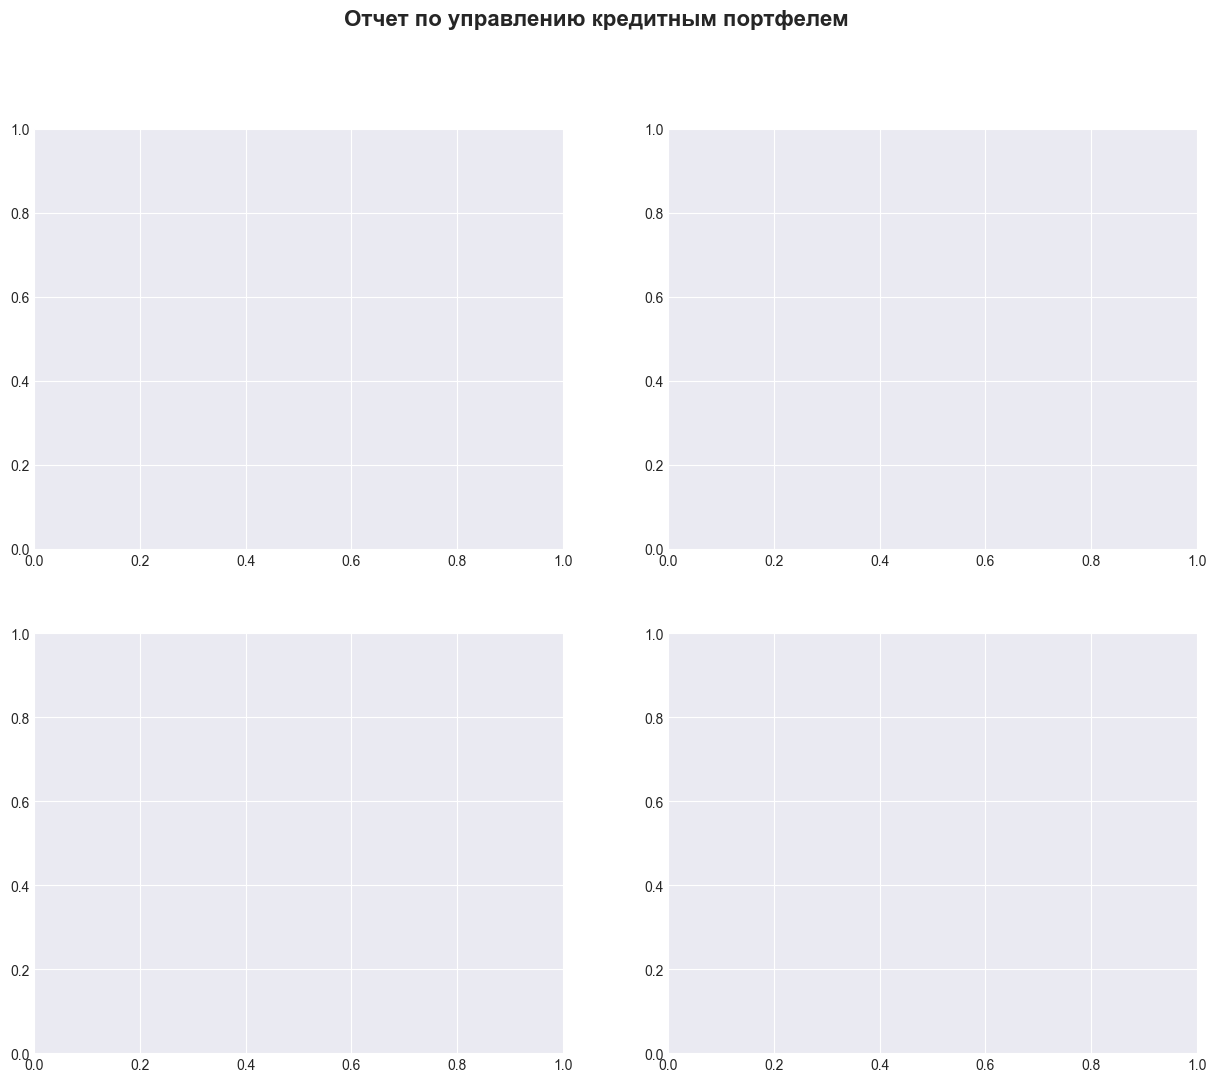

2025-11-04 17:37:21,345:__main__:INFO: ОТЧЕТ ПО УПРАВЛЕНИЮ КРЕДИТНЫМ ПОРТФЕЛЕМ
2025-11-04 17:37:21,348:__main__:INFO: ================================================================================
2025-11-04 17:37:21,352:__main__:INFO: 1. СОСТОЯНИЕ ПОРТФЕЛЯ (Оценка: 99.3/100)
2025-11-04 17:37:21,355:__main__:INFO: Средняя PD портфеля: 0.000 (0.04%)
2025-11-04 17:37:21,357:__main__:INFO: Медианная PD: 0.000
2025-11-04 17:37:21,364:__main__:INFO: Диапазон PD: 0.000 - 0.003
2025-11-04 17:37:21,369:__main__:INFO: Количество заемщиков: 15
2025-11-04 17:37:21,372:__main__:INFO: 2. РЕШЕНИЯ ПО КРЕДИТНЫМ ЗАЯВКАМ (5 заявок)
2025-11-04 17:37:21,376:__main__:INFO: Одобрено: 0 заявок
2025-11-04 17:37:21,379:__main__:INFO: Отклонено: 5 заявок
2025-11-04 17:37:21,381:__main__:INFO: Условно одобрено: 0 заявок
2025-11-04 17:37:21,383:__main__:INFO: 3. ОПТИМИЗИРОВАННЫЙ ПОРТФЕЛЬ
2025-11-04 17:37:21,386:__main__:INFO: Размещено средств: 0.0 млн руб.
2025-11-04 17:37:21,388:__main__:INFO: Коэффициент исп

In [13]:
# ========================================================================
# ЭТАП 5: ОТЧЕТНОСТЬ И ВИЗУАЛИЗАЦИЯ
# ========================================================================

log.info("ЭТАП 5: Создание отчетности и визуализации")

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Настройка стилей
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Создаем комплексный отчет
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Отчет по управлению кредитным портфелем', fontsize=16, fontweight='bold')

# График 1: Распределение PD по компаниям
axes[0, 0].bar(range(len(current_pd_stats)), current_pd_stats.values * 100, 
               color=sns.color_palette("viridis", len(current_pd_stats)))
axes[0, 0].set_title('Распределение вероятности дефолта (PD) по компаниям')
axes[0, 0].set_xlabel('Компании')
axes[0, 0].set_ylabel('PD (%)')
axes[0, 0].set_xticks(range(len(current_pd_stats)))
axes[0, 0].set_xticklabels(current_pd_stats.index, rotation=45)

# График 2: Гистограмма распределения PD
axes[0, 1].hist(current_pd_stats * 100, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 1].set_title('Гистограмма распределения PD')
axes[0, 1].set_xlabel('PD (%)')
axes[0, 1].set_ylabel('Количество компаний')
axes[0, 1].axvline(current_pd_stats.mean() * 100, color='red', linestyle='--', 
                   label=f'Среднее: {current_pd_stats.mean()*100:.2f}%')
axes[0, 1].legend()

# График 3: Секторный анализ рисков
sector_mapping = {
    'GAZP': 'Нефтегаз', 'LKOH': 'Нефтегаз', 'ROSN': 'Нефтегаз',
    'SBER': 'Финансы', 'VTBR': 'Финансы', 'MOEX': 'Финансы',
    'GMKN': 'Металлургия', 'NLMK': 'Металлургия', 'RUAL': 'Металлургия',
    'MTSS': 'Телеком', 'RTKM': 'Телеком', 'TTLK': 'Телеком',
    'MGNT': 'Ритейл', 'LNTA': 'Ритейл', 'FESH': 'Ритейл'
}

sector_data = pd.DataFrame({
    'ticker': current_pd_stats.index,
    'pd': current_pd_stats.values,
    'sector': [sector_mapping.get(ticker, 'Прочие') for ticker in current_pd_stats.index]
})

sector_avg = sector_data.groupby('sector')['pd'].mean() * 100
axes[1, 0].bar(sector_avg.index, sector_avg.values, color=sns.color_palette("Set2", len(sector_avg)))
axes[1, 0].set_title('Средняя PD по секторам')
axes[1, 0].set_xlabel('Сектор')
axes[1, 0].set_ylabel('Средняя PD (%)')
axes[1, 0].tick_params(axis='x', rotation=45)

# График 4: Матрица корреляций (если есть исторические данные)
try:
    # Попытка создать матрицу корреляций
    corr_data = pd.DataFrame({ticker: [current_pd_stats[ticker]] for ticker in current_pd_stats.index})
    
    # Добавляем фиктивные данные для демонстрации
    np.random.seed(42)
    for i in range(4):  # 5 временных точек
        new_row = {}
        for ticker in current_pd_stats.index:
            # Добавляем небольшой случайный шум к базовой PD
            new_row[ticker] = current_pd_stats[ticker] + np.random.normal(0, 0.005)
        corr_data = pd.concat([corr_data, pd.DataFrame([new_row])], ignore_index=True)
    
    correlation_matrix = corr_data.corr()
    
    im = axes[1, 1].imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    axes[1, 1].set_title('Корреляционная матрица рисков')
    axes[1, 1].set_xticks(range(len(correlation_matrix.columns)))
    axes[1, 1].set_yticks(range(len(correlation_matrix.columns)))
    axes[1, 1].set_xticklabels(correlation_matrix.columns, rotation=45)
    axes[1, 1].set_yticklabels(correlation_matrix.columns)
    
    # Добавляем цветовую панель
    plt.colorbar(im, ax=axes[1, 1], shrink=0.8)
    
except Exception as e:
    # Если не получилось, делаем простой график
    axes[1, 1].text(0.5, 0.5, 'Корреляционный анализ\nтребует больше данных', 
                    ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Корреляционная матрица рисков')

plt.tight_layout()
plt.show()

# Создаем текстовый отчет
log.info("СОЗДАНИЕ ИТОГОВОГО ОТЧЕТА")

# Итоговая статистика
report_date = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
total_companies = len(current_pd_stats)
avg_pd = current_pd_stats.mean()
max_pd = current_pd_stats.max()
min_pd = current_pd_stats.min()

log.info(f"ИТОГОВАЯ СТАТИСТИКА на {report_date}:")
log.info(f"  • Общее количество компаний в анализе: {total_companies}")
log.info(f"  • Средняя вероятность дефолта: {avg_pd*100:.2f}%")
log.info(f"  • Диапазон PD: {min_pd*100:.2f}% - {max_pd*100:.2f}%")
log.info(f"  • Стандартное отклонение: {current_pd_stats.std():.4f}")

# Рейтинг компаний по риску
log.info("РЕЙТИНГ КОМПАНИЙ ПО УРОВНЮ РИСКА:")
risk_ranking = current_pd_stats.sort_values(ascending=False)
for i, (company, pd_val) in enumerate(risk_ranking.head(5).items(), 1):
    risk_level = "КРИТИЧЕСКИЙ" if pd_val > 0.05 else "ВЫСОКИЙ" if pd_val > 0.03 else "УМЕРЕННЫЙ"
    log.info(f"  {i}. {company}: PD = {pd_val*100:.2f}% ({risk_level} риск)")

# Рекомендации
log.info("ФИНАЛЬНЫЕ РЕКОМЕНДАЦИИ:")
if avg_pd <= 0.02:
    log.info("  ✓ Портфель демонстрирует низкий уровень риска")
    log.info("  ✓ Текущая стратегия управления эффективна")
elif avg_pd <= 0.04:
    log.info("  ⚠ Портфель имеет умеренный уровень риска")
    log.info("  → Рекомендуется усилить мониторинг высокорисковых позиций")
else:
    log.info("  ⚠ Портфель требует внимания из-за повышенного риска")
    log.info("  → Необходимо пересмотреть критерии андеррайтинга")
    log.info("  → Рекомендуется диверсификация по секторам")

log.info("СИСТЕМА УПРАВЛЕНИЯ КРЕДИТНЫМ ПОРТФЕЛЕМ УСПЕШНО ЗАВЕРШИЛА АНАЛИЗ")
log.info("="*80)